# Group members: 
# 1 - Mohammad Kachmar    
# 2 - Serge Ohannessian

# A. Data import
### 1. Import the dataset into a DataFrame.

In [138]:
import pandas as pd
df = pd.read_csv("adult.csv")

### 2. In a pie chart, display the class distribution (percentage of people in the dataset with
### income <=50 K versus income>50K)

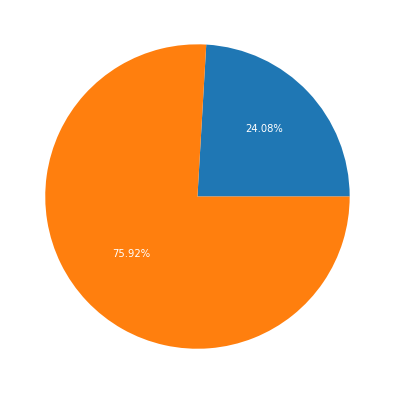

In [139]:

# Import libraries
import numpy as np
import matplotlib.pyplot as plt


 
data = [sum(df['Income'] == ' >50K'), sum(df['Income'] == ' <=50K')]
labels = ['>50K', '<=50K']
 
def func(value, allvalues):
    absolute = int(value / 100.*np.sum(allvalues))
    return "{:.2f}%\n".format(value, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
ax.pie(data, autopct = lambda value: func(value, data), labels = labels, textprops = dict(color ="white"))
 
plt.show()

### 3. Check whether we have missing values. What is the percentage of rows with missing
### data?

In [140]:
columns = ['Age','Workclass','fnlwgt','Education','Education Number','Marital Status','Occupation','Relationship','Race','Gender','Capital Gain','Capital Loss','Hours per week','Native Country','Income']
for column in columns:
    df.loc[df[column] == " ?", column] = None
missingDataRows = sum(df.isna().any(axis=1)) # check if ' ?' null value exists in any of the columns (axis 1)
print("{:.2f}%".format(missingDataRows/len(df['Income']) * 100))



7.37%


# B. Data preprocessing (3 pts)
### 1. For each feature, replace missing values with the mode (categorical features) or the
### mean (numerical features).

In [141]:
columns_with_nans = []
for i in columns:
    if not df[df.isna()[i]].empty :   #check if columns has nan values
        columns_with_nans.append(i)   # append the column if so

replacement_values = df.mode()[columns_with_nans]   #store the modes of those columns in another df
for i in range(len(columns_with_nans)):
    df[columns_with_nans[i]] = df[columns_with_nans[i]].fillna(replacement_values[columns_with_nans[i]][0])  #for each column replace the nan with the mode of that column



### 2. Plot a box plot for each numerical feature by splitting on the label (<=50K and >50K).
### Can you spot any outliers?


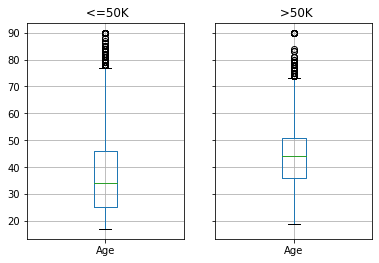

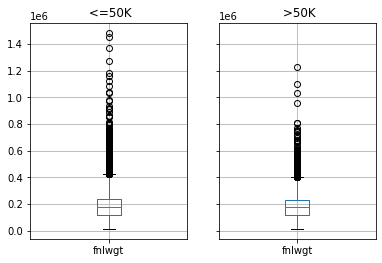

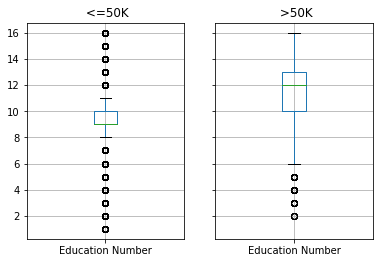

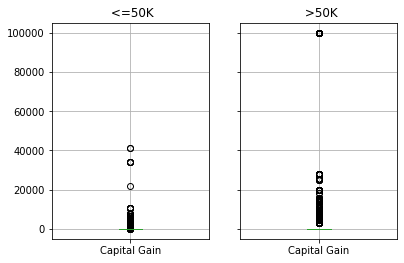

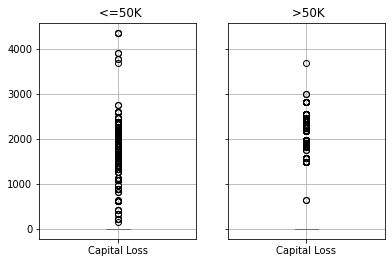

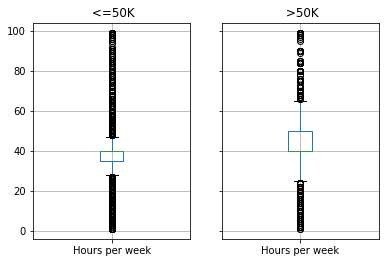

In [142]:
numerical_columns = (df.select_dtypes(include=np.number).columns.tolist())
for i in numerical_columns:
    df.groupby('Income').boxplot(column=i)
    plt.show()

### 3. Normalize numerical features. State which normalization method you chose.


In [143]:
print(df.var())
df[numerical_columns] = np.log(df[numerical_columns]+1)   #using log normalization and adding a constant to handle 0's 
print(df.var())

Age                 1.860614e+02
fnlwgt              1.114080e+10
Education Number    6.618890e+00
Capital Gain        5.454254e+07
Capital Loss        1.623769e+05
Hours per week      1.524590e+02
dtype: float64
Age                 0.122522
fnlwgt              0.397830
Education Number    0.074975
Capital Gain        6.025737
Capital Loss        2.510897
Hours per week      0.149780
dtype: float64


### 4. Split your dataset into 80% training and 20% testing.


### 5. Transform categorical data into numerical using one-hot encoding.

### 6. Use LabelEncoder from sklearn.preprocessing to deal with the non-numerical
### output. 

In [144]:
from sklearn.model_selection import train_test_split

X = df[columns[:-1]]
y = df["Income"]

#5. Transform categorical data into numerical using one-hot encoding.
X = pd.get_dummies(X)


# 6. Use LabelEncoder from sklearn.preprocessing to deal with the non-numerical output. 
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y = LE.fit_transform(y)

# 4. Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,stratify=y)

# C. Modeling – Shallow Models (8 pts)
### 1. Decision tree
#### a. Split the 80% of your data into training and validation (choice of split percentage is left to you)

In [145]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train,y_train,test_size= 0.2,stratify=y_train)


#### b. Train a decision tree classifier

In [146]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_1,y_train_1)

DecisionTreeClassifier()

#### c. Fine-tune your classifier on different hyperparameters on the validation set


In [147]:
params_rf = {
    'max_depth': [20,40,60,80,100,120],
    'min_samples_leaf': [0.04,0.06,0.08],
    'max_features': [0.2,0.4,0.6,0.8]
}
from sklearn.model_selection import GridSearchCV

grid_dt = GridSearchCV(estimator=dt,param_grid=params_rf,cv=5)
grid_dt.fit(X_test_1,y_test_1)
best_hyperparams = grid_dt.best_params_


#### d. Report the best hyper-parameters and the highest performance on the validation set


In [148]:
print(best_hyperparams)
best_CV_score = grid_dt.best_score_
print(best_CV_score)

{'max_depth': 20, 'max_features': 0.4, 'min_samples_leaf': 0.04}
0.8351247600767755


### 2. Logistic regression
#### a. On the full 80% data, train a linear regression model


In [149]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=1500)
LR.fit(X_train, y_train)


LogisticRegression(max_iter=1500)

#### b. Finetune your model through a 5-fold cross validation

In [150]:
LRparam_grid = {
    'C': [0.001, 0.01, 0.1],
    "fit_intercept": [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
LR_search = GridSearchCV(estimator=LR, param_grid=LRparam_grid, cv=5,)

# fitting the model for grid search 
LR_search.fit(X_test , y_test)
LR_search_score = LR_search.best_score_
LR_search_param = LR_search.best_params_
# summarize
print(LR_search_score)
print(LR_search_param)

# print(lr.get_params())

0.834945470278325
{'C': 0.1, 'fit_intercept': True, 'solver': 'sag'}


# D. Modeling – Neural Networks (4 pts)
### a. On the full 80% data, for 200 epochs, train a neural network with 5-fold cross validation


In [151]:
from keras.models import Sequential 
from keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


def create_model():
    model = Sequential()
    size = X_train.columns.size
    model.add(Dense(14,input_shape=(size,), activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_model,epochs = 200)


from sklearn.model_selection import cross_val_score

kfold = cross_val_score(model, X_train, y_train, cv=5)
kfold.mean()


Epoch 1/200
652/652 [==============================] - 0s 424us/step - loss: 0.5331 - accuracy: 0.7591
Epoch 2/200
652/652 [==============================] - 0s 429us/step - loss: 0.4982 - accuracy: 0.7721
Epoch 3/200
652/652 [==============================] - 0s 435us/step - loss: 0.4743 - accuracy: 0.7940
Epoch 4/200
652/652 [==============================] - 0s 430us/step - loss: 0.4516 - accuracy: 0.7956
Epoch 5/200
652/652 [==============================] - 0s 438us/step - loss: 0.4312 - accuracy: 0.8012
Epoch 6/200
652/652 [==============================] - 0s 436us/step - loss: 0.4141 - accuracy: 0.8037
Epoch 7/200
652/652 [==============================] - 0s 439us/step - loss: 0.4009 - accuracy: 0.8077
Epoch 8/200
652/652 [==============================] - 0s 435us/step - loss: 0.3913 - accuracy: 0.8107
Epoch 9/200
652/652 [==============================] - 0s 436us/step - loss: 0.3840 - accuracy: 0.8167
Epoch 10/200
652/652 [==============================] - 0s 419us/step - l

0.8444799423217774

### b. Plot the training and validation error per epoch


Epoch 1/200
814/814 [==============================] - 1s 555us/step - loss: 0.5377 - accuracy: 0.7532 - val_loss: 0.5097 - val_accuracy: 0.7612
Epoch 2/200
814/814 [==============================] - 0s 503us/step - loss: 0.4876 - accuracy: 0.7855 - val_loss: 0.4733 - val_accuracy: 0.7889
Epoch 3/200
814/814 [==============================] - 0s 466us/step - loss: 0.4553 - accuracy: 0.7933 - val_loss: 0.4492 - val_accuracy: 0.7967
Epoch 4/200
814/814 [==============================] - 0s 470us/step - loss: 0.4314 - accuracy: 0.8023 - val_loss: 0.4286 - val_accuracy: 0.7969
Epoch 5/200
814/814 [==============================] - 0s 471us/step - loss: 0.4118 - accuracy: 0.8044 - val_loss: 0.4131 - val_accuracy: 0.7981
Epoch 6/200
814/814 [==============================] - 0s 474us/step - loss: 0.3977 - accuracy: 0.8076 - val_loss: 0.4028 - val_accuracy: 0.7969
Epoch 7/200
814/814 [==============================] - 0s 476us/step - loss: 0.3875 - accuracy: 0.8140 - val_loss: 0.3945 - val_ac

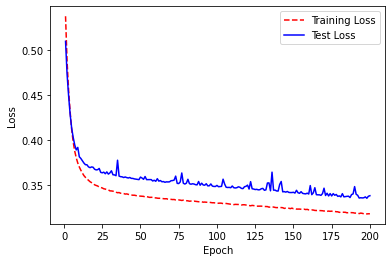

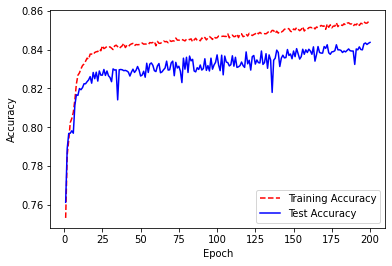

In [152]:
h_callback = model.fit(X_train, y_train, epochs = 200,validation_data=(X_test, y_test))


training_loss = h_callback.history['loss']
test_loss = h_callback.history['val_loss']
training_acc = h_callback.history['accuracy']
test_acc = h_callback.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### c. BONUS: implement an early stopping criterion using callbacks

In [153]:
from keras.callbacks import EarlyStopping
model.fit(X_train, y_train, epochs=100,verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=1)])

# E. Testing (3 pts)
### a. Based on the validation error, which model is the best?

LogisticRegression has the highest Accuracy so its the best model

### b. Report the performance metrics (accuracy, f-measure, precision, recall) on testing data


In [154]:
from sklearn.metrics import classification_report

predicted = LR.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4945
           1       0.69      0.57      0.62      1568

    accuracy                           0.83      6513
   macro avg       0.78      0.74      0.76      6513
weighted avg       0.83      0.83      0.83      6513



### c. Compute the percentage of women with prediction of income >=50k in the testing set?


In [155]:
women_rich = 0
women_poor = 0
total = y_test.shape[0]
for i in range(total):
    if ((X_test.iloc[i]["Gender_ Female"]==1) and predicted[i]==1):
        women_rich+=1
    elif ((X_test.iloc[i]["Gender_ Female"]==1) and predicted[i]==0):
        women_poor+=1

print("percentage of women predicted with an income >=50k versus women with an income of <=50k:", (women_rich/(women_rich+women_poor))*100, "%")

percentage of women predicted with an income >=50k versus women with an income of <=50k: 6.701520912547529 %


### d. Compute the percentage of men with prediction of income >=50k in the testing set?


In [156]:
men_rich = 0
men_poor = 0
total = y_test.shape[0]
for i in range(total):
    if ((X_test.iloc[i]["Gender_ Male"]==1) and predicted[i]==1):
        men_rich+=1
    elif ((X_test.iloc[i]["Gender_ Male"]==1) and predicted[i]==0):
        men_poor+=1

print("percentage of men predicted with an income >=50k versus men with an income of <=50k:", (men_rich/(men_rich+men_poor))*100, "%")

percentage of men predicted with an income >=50k versus men with an income of <=50k: 26.241778180993425 %


### e. Comment on the fairness of your model 